In [10]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:


# 1. Load and Prepare Data
def load_data():
    # Load weekly data for seasons 2021-2023
    df = nfl.import_weekly_data([2021, 2022, 2023])
    # Filter regular season games and QBs only
    df = df[(df['season_type'] == 'REG')]
    return df

def preprocess_data(df):
    # Select features available before each week
    features = ['player_id', 'season', 'week', 'opponent_team', 'recent_team']
    target = 'fantasy_points'

    # Ensure no leakage by dropping all columns not usable for future predictions
    df = df[features + [target]].dropna(subset=[target])

    # Encode player_id as integer
    df['player_id'] = df['player_id'].str.replace('00-', '').astype(int)

    return df, features, target

# 2. Data Splitting
def split_data(df, features, target):
    X = df[features]
    y = df[target]

    # Split data into train and test sets
    return train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create Pipeline and Train Model
def create_pipeline():
    numeric_features = ['player_id', 'season', 'week']
    categorical_features = ['opponent_team', 'recent_team']

    # Preprocessor for numeric and categorical features
    preprocessor = ColumnTransformer(transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown='ignore'), categorical_features),
    ])

    # Create pipeline with preprocessor and XGBoost model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
    ])

    return pipeline

# 4. Train and Evaluate Model
def train_and_evaluate(pipeline, X_train, X_test, y_train, y_test):
    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

    return pipeline, y_pred

# 5. Visualization
def visualize_results(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
    plt.xlabel("Actual Fantasy Points")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("Actual vs Predicted Fantasy Points")
    plt.show()

def printMetricResults(metric):
    for name, model in zip(
        ['Linear Regression', 'Explainable Boosting Machine', 'Multi Layer Perceptron', 'XGBoost'],
        [lr, ebm, mlp, xgb]
    ):
        print(f'{name:30}{metric(y_test, model.predict(X_test))}')




Downcasting floats.
Mean Absolute Error: 4.4674296379089355
R^2 Score: 0.2604641914367676


/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_5803/4024090087.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


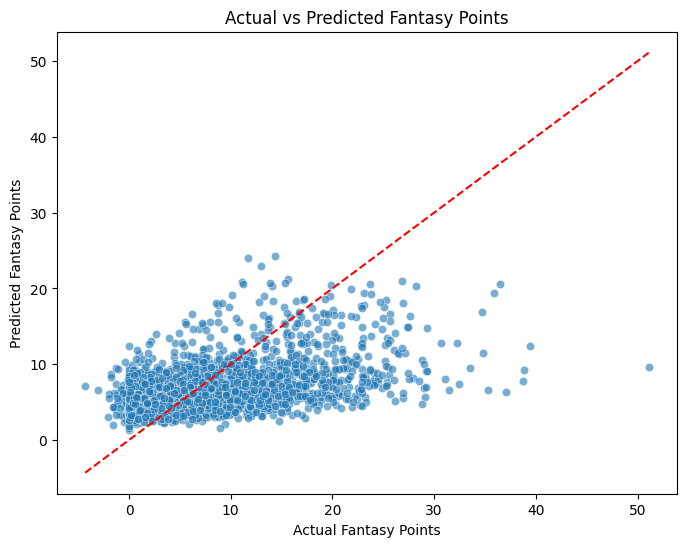

In [13]:
# Main Workflow
def main():
    # Load and preprocess data
    df = load_data()
    df, features, target = preprocess_data(df)

    # Split data
    X_train, X_test, y_train, y_test = split_data(df, features, target)

    # Create pipeline
    pipeline = create_pipeline()

    # Train and evaluate
    pipeline, y_pred = train_and_evaluate(pipeline, X_train, X_test, y_train, y_test)

    # Visualize results
    visualize_results(y_test, y_pred)

if __name__ == "__main__":
    main()